# Ask a Manager Survey Analisis (2023)

### Introduction:

At this project I will analyse a survey data from 2023 which provides information about 17.000 peoples jobs, salary, education by age and country. Analysing this dataset could give us many insights about the job market nowadays, and helps us to better understand which carrer paths has the biggest opportunities from the viewpont of salaries and personal grow. 

In this notebook I would like showcase my data analisation skills with different python libraries to get valuable informations from the data.




### Step 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re

In [2]:
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

### Step 2. Reading and cleaning the data

In [3]:
raw = pd.read_csv('Ask_a_Manager.csv') 

In [4]:
# Dropping irrelevant columns.
df = raw.drop(['Timestamp','Job title - additional context','Income - additional context','Currency - other'], axis=1)
df = df.rename(columns={'highest level of education completed': 'education'})

# Formatting column names for easier usability.
df.columns = df.columns.str.lower()
df. columns = [x.replace (' ','_' ) for x in df.columns]

In [5]:
print(df.isna().sum())
# We can see most of the relevant columns for our analisis has no NaN values. Althought we want to make some analisis connected to education, industry, and the affects of working area on the salaries.
# Replacing these values would not be effective, so we will remove this ca. 250 records from our data.

how_old_are_you?                           0
industry                                  46
functional_area_of_job                   111
job_title                                  0
annual_salary_(gross)                      0
additional_monetary_compensation        4016
currency                                   0
country                                    0
state                                   2983
city                                      68
remote_or_on-site?                        64
years_of_experience,_overall               0
years_of_experience_in_field               0
highest_level_of_education_completed      49
gender                                    83
race                                      69
dtype: int64


In [6]:
df.dropna(subset=['industry', 'functional_area_of_job','remote_or_on-site?', 'highest_level_of_education_completed'], how='any', inplace=True)

# We are assuming, if there is no answer at additional_compensation it means 0 compensation. 
df.fillna({'additional_monetary_compensation': 0}, inplace=True)

In [7]:
# Checking and removing duplicates with default drop settings.
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

14


In [8]:
df.shape
# At the end of our data cleaning we got 16881 rows and 16 columns in the dataframe.

(16881, 16)

In [9]:
df.sample(5)

,how_old_are_you?,industry,functional_area_of_job,job_title,annual_salary_(gross),additional_monetary_compensation,currency,country,state,city,remote_or_on-site?,"years_of_experience,_overall",years_of_experience_in_field,highest_level_of_education_completed,gender,race
4851,35-44,Education (Higher Education),Education (Higher Education),Chair & Associate Professor,165000,0.00,USD,United States,Florida,Gainesville,On-site,11-20 years,11-20 years,PhD,Woman,White
12478,35-44,Nonprofits,Administration,Senior Executive Assistant,70000,0.00,USD,United States,Minnesota,Minneapolis,Hybrid,21-30 years,11-20 years,College degree,Woman,White
11541,35-44,Nonprofits,"Marketing, Advertising & PR",Marketing and communications manager,83000,0.00,USD,United States,Pennsylvania,Philadelphia,Fully remote,11-20 years,11-20 years,College degree,Woman,White
6501,25-34,"Accounting, Banking & Finance",Administration,Administrative Assistant,86500,4325.00,USD,United States,Massachusetts,Boston,Hybrid,11-20 years,5-7 years,Some college,Woman,White
903,55-64,Education (Primary/Secondary),Education (Primary/Secondary),Math Teacher,105000,0.00,USD,United States,Massachusetts,Marlborough,On-site,31-40 years,21-30 years,PhD,Woman,White


### Step 3. Getting informations about the persona of the survey

In [10]:
# Proportion of genders in the answers
(df.gender.value_counts(normalize=True)*100).to_frame('proportion (%)').head(5)

,proportion (%)
gender,
Woman,76.79
Man,17.28
Non-binary,3.65
Other or prefer not to answer,0.90
"Woman, Non-binary",0.89


In [11]:
# Top 5 most represented race
(df['race'].value_counts(normalize=True)*100).to_frame('proportion (%)').head(5)

,proportion (%)
race,
White,87.30
Asian or Asian American,3.16
Another option not listed here or prefer not to answer,1.78
Black or African American,1.72
"Hispanic, Latino, or Spanish origin",1.69


In [12]:
# Age distribution
(df['how_old_are_you?'].value_counts(normalize=True)*100).to_frame('proportion (%)')

,proportion (%)
how_old_are_you?,
35-44,41.08
25-34,34.89
45-54,16.02
55-64,5.33
18-24,2.07
65 or over,0.59
under 18,0.02


In [13]:
# Highest level of education
(df['highest_level_of_education_completed'].value_counts(normalize=True)*100).to_frame('proportion (%)').head(6)

,proportion (%)
highest_level_of_education_completed,
College degree,45.26
Master's degree,33.55
Some college,6.85
PhD,6.40
"Professional degree (MD, JD, etc.)",5.22
High School,1.59


### Step 4. Basic informations about the data

In [14]:
# Top 5 most represented countries and mean salaries in the survey. 
# The problem is the total_compensation column includes the salaries in each country's own currency, so the comparision is not effective.
currencies_to_usd = {'Canada': 0.7392, 'United States': 1, 'Germany' : 1.0867, 'United Kingdom': 1.2345, 'Australia': 0.6688}

top_5 = df.groupby('country').agg({'annual_salary_(gross)' : 'mean', 'job_title': 'count', 'additional_monetary_compensation': 'mean'}).sort_values('job_title', ascending=False).rename(columns={'job_title':'job_count'}).head(5)
top_5['compensation_usd (mean)'] = top_5.index.map(currencies_to_usd) * top_5['annual_salary_(gross)']
top_5['additonal_money_usd (mean)'] = top_5.index.map(currencies_to_usd) * top_5['additional_monetary_compensation']
top_5.loc[:,['job_count','compensation_usd (mean)','additonal_money_usd (mean)']].sort_values('compensation_usd (mean)', ascending=False)

,job_count,compensation_usd (mean),additonal_money_usd (mean)
country,,,
United States,14009,101504.74,8987.16
Australia,282,76240.90,4351.35
Germany,130,76005.10,5222.78
United Kingdom,854,67484.02,4422.45
Canada,1078,66723.09,3580.33


In [15]:
# How many companies pay additional money besides salary ? 
additional_percentage = len(df[df['additional_monetary_compensation'] > 0])/len(df)*100
print(f'{additional_percentage:.2f}% of the jobs payed additional compensation in 2023.')

47.32% of the jobs payed additional compensation in 2023.


In [16]:
# We can see the highest salaries in 2023 were connected to the USA.
# Another important point is the additonal compensations, which helps to keep and motivate the employees of the companies in each country. 
# From this viewpoint the USA is also outstanding, it might be because of the bigger competition between the companies there. 

In [17]:
# We could see earlier that about 80% of the submissions is from the United States, but all in all there are records from 115 different countries. 
# To make our analisis effective I will specifiy on only the records  from the USA.
df_usa = df.query('country == "United States"')
# We exclude rows with 0.00 salaries.
df_usa = df_usa[df_usa['annual_salary_(gross)'] != 0] 

In [18]:
df_usa.describe()

,annual_salary_(gross),additional_monetary_compensation
count,14007.00,14007.00
mean,101519.23,8980.84
std,74285.89,32546.37
min,35.00,0.00
25%,63259.00,0.00
50%,87500.00,0.00
75%,124000.00,7000.00
max,3000000.00,1300000.00


In [19]:
# What is the top 10 most occuring job title in the dataset ? 
df_usa.job_title.value_counts().to_frame().head(10)

,count
job_title,
Project Manager,117
Director,109
Program Manager,92
Senior Software Engineer,91
Teacher,73
Manager,70
Software Engineer,60
Librarian,58
HR Manager,51


In [20]:
# Industry representation
industry_counts = df_usa.industry.value_counts().to_frame().head(10)
total_count = df_usa.industry.count()
industry_counts['Percentage (%)']  = industry_counts['count'] / total_count *100
industry_counts 

,count,Percentage (%)
industry,,
Education (Higher Education),1571,11.22
Computing or Tech,1490,10.64
Nonprofits,1313,9.37
Health care,1150,8.21
Government & Public Administration,1056,7.54
Engineering or Manufacturing,872,6.23
"Accounting, Banking & Finance",756,5.40
Education (Primary/Secondary),499,3.56
Biotechnology & Pharma,472,3.37


In [21]:
# How many people working remote or on-site nowadays in the USA ? 
(df_usa['remote_or_on-site?'].value_counts(normalize=True)*100).to_frame('proportion (%)')

,proportion (%)
remote_or_on-site?,
Hybrid,39.42
On-site,31.16
Fully remote,27.26
Other/it's complicated,2.16


In [22]:
#In which states do they pay the highest mean salaries ? 
states_list = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", 
    "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", 
    "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", 
    "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", 
    "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", 
    "New Hampshire", "New Jersey", "New Mexico", "New York", 
    "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", 
    "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", 
    "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", 
    "West Virginia", "Wisconsin", "Wyoming", "District of Columbia"
]
# We needed this list because in the original df there were several rows which included two states name in one row, so we excluded these records.
print(df_usa.groupby('state')['annual_salary_(gross)'].mean().sort_values().head(1))
single_state = df_usa[df_usa['state'].isin(states_list)]

single_state.groupby('state')['annual_salary_(gross)'].mean().sort_values(ascending=False).to_frame().head(10)

state
Missouri, New Mexico   48500.00
Name: annual_salary_(gross), dtype: float64


,annual_salary_(gross)
state,
California,129886.87
District of Columbia,126858.13
Washington,113051.63
Massachusetts,112240.86
New York,109794.60
Georgia,104925.08
Colorado,103668.95
Maryland,103409.24
New Hampshire,103089.57


## Step 5. Manager analisation

In [23]:
# We could see that most of the answers in the job_title included the word of manager.
# In my further analisis I will create a label depending on these rows and analyse and compare them from different aspects. 

df_usa["is_manager"] = np.where(df_usa["job_title"].str.contains('manager|Manager|head|Head', regex=True, na=False), 'yes', 'no')
managers = df_usa[df_usa.is_manager == 'yes']
managers.sample(2)

,how_old_are_you?,industry,functional_area_of_job,job_title,annual_salary_(gross),additional_monetary_compensation,currency,country,state,city,remote_or_on-site?,"years_of_experience,_overall",years_of_experience_in_field,highest_level_of_education_completed,gender,race,is_manager
9688,45-54,Nonprofits,Health care,Operations Manager,110000,0.00,USD,United States,Massachusetts,Boston,Fully remote,21-30 years,11-20 years,College degree,Woman,White,yes
1486,25-34,Transport or Logistics,Business or Consulting,Corporate Manager,184000,73600.00,USD,United States,California,Los Angeles,Hybrid,2-4 years,11-20 years,Master's degree,Woman,White,yes


In [24]:
# What is the most common age between managers ? 
(managers['how_old_are_you?'].value_counts(normalize=True)*100).to_frame('Percentage (%)').sort_values('Percentage (%)', ascending=False)

,Percentage (%)
how_old_are_you?,
35-44,43.09
25-34,33.30
45-54,16.78
55-64,5.38
18-24,0.74
65 or over,0.71


In [25]:
# How much working experience do managers have/need usually ? 
(managers['years_of_experience_in_field'].value_counts(normalize=True)*100).to_frame('Percentage (%)').sort_values('Percentage (%)', ascending=False)

,Percentage (%)
years_of_experience_in_field,
11-20 years,30.41
8-10 years,22.07
5-7 years,21.80
2-4 years,12.45
21-30 years,8.98
1 year or less,2.29
31-40 years,1.88
41 years or more,0.13


In [26]:
# Gender of managers
managers.value_counts('gender').to_frame().head(5)

,count
gender,
Woman,2367
Man,473
Non-binary,69
"Woman, Non-binary",23
Other or prefer not to answer,19


In [27]:
# Highest level education proportion
managers.highest_level_of_education_completed.value_counts().to_frame().head(6)

,count
highest_level_of_education_completed,
College degree,1513
Master's degree,1005
Some college,244
PhD,75
"Professional degree (MD, JD, etc.)",67
High School,47


In [28]:
# Basic statistics about manager salaries and additional compensations
managers.describe()

,annual_salary_(gross),additional_monetary_compensation
count,2973.00,2973.00
mean,107144.66,11044.57
std,70316.89,30054.00
min,35.00,0.00
25%,72000.00,0.00
50%,96500.00,2000.00
75%,130000.00,12000.00
max,1720000.00,550000.00


In [29]:
# How the salaries of managers differentiate depending on different industries ? 
managers = df_usa[df_usa.is_manager == 'yes']
managers.groupby('industry').filter(lambda x: len(x) >= 50).groupby('industry').agg({'annual_salary_(gross)': 'mean'}).sort_values('annual_salary_(gross)', ascending=False).head(10)

,annual_salary_(gross)
industry,
Biotechnology & Pharma,148276.60
Computing or Tech,147568.59
Transport or Logistics,126476.28
Business or Consulting,124488.16
"Accounting, Banking & Finance",124368.13
Engineering or Manufacturing,118390.31
Utilities & Telecommunications,117873.10
Insurance,107467.13
Health care,107249.52


In [30]:
# Most occuring types of managers
managers.job_title.value_counts().to_frame().head(10)

,count
job_title,
Project Manager,117
Program Manager,92
Manager,70
HR Manager,51
Operations Manager,45
Product Manager,44
Office Manager,42
Senior Manager,40
Marketing Manager,36


In [31]:
# All in all how much do managers make compared to other levels? 
# pd.set_option('display.max_rows', None)
# print(df_usa.job_title)   With this code we can see all the records and get information about the keywords we need.

# We could do this at the manager dataset also, but because of the readability of the code I decided to make a new dataframe.
df_levels_all = df
conditions = [
    df["job_title"].str.contains('entry|junior', flags=re.IGNORECASE, na=False),
    df["job_title"].str.contains('mid|medior', flags=re.IGNORECASE, na=False),
    df["job_title"].str.contains('manager', flags=re.IGNORECASE, na=False),
    df["job_title"].str.contains('senior|specialist', flags=re.IGNORECASE, na=False),
    df["job_title"].str.contains('lead|vp|vice president|head|director', flags=re.IGNORECASE, na=False)
]
choices = ['junior', 'medior', 'manager', 'senior', 'director']
df_levels_all['level'] = np.select(conditions, choices, default='other') # Contains not only the categorized jobs.
df_levels = df_levels_all[df_levels_all.level != 'other']
salaries_by_levels = df_levels.groupby('level').mean('annual_salary_(gross)').sort_values('annual_salary_(gross)', ascending=False)
salaries_by_levels


,annual_salary_(gross),additional_monetary_compensation
level,,
director,129605.63,15389.78
senior,117031.03,9525.20
manager,112824.63,10375.27
medior,72674.36,5096.43
junior,66844.32,1805.41


In [32]:
print(f'Our filtered data contains {df_levels.shape[0]} rows and {df_levels.shape[1]} columns.')

Our filtered data contains 8196 rows and 17 columns.


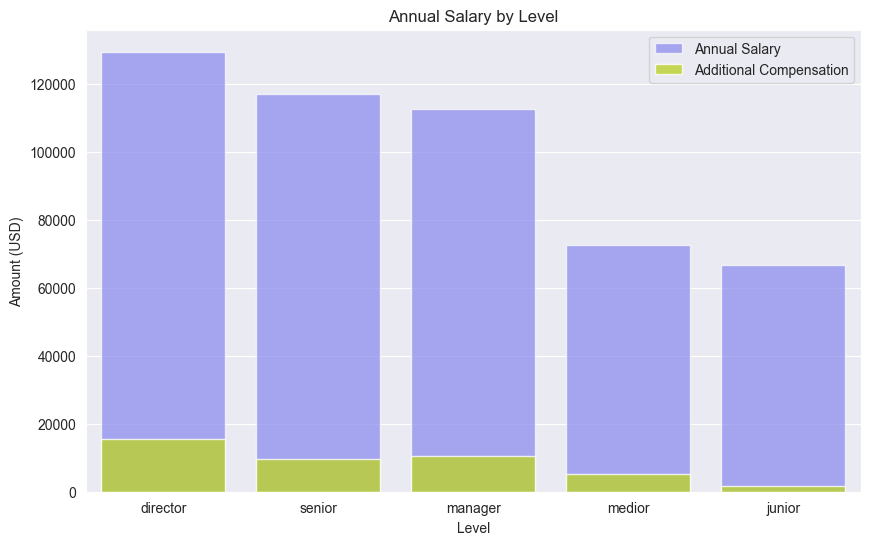

In [33]:
# Salary and additional money distribution categorized by levels

salaries_by_levels["level"] = salaries_by_levels.index
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

sns.barplot(data=salaries_by_levels, x="level", y="annual_salary_(gross)", color="#7777ff", alpha=0.7, label='Annual Salary')
sns.barplot(data=salaries_by_levels, x='level', y='additional_monetary_compensation', color='#d0ee11', alpha=0.8, label='Additional Compensation')

plt.title("Annual Salary by Level")
plt.legend()
plt.ylabel("Amount (USD)")
plt.xlabel("Level")

plt.show()

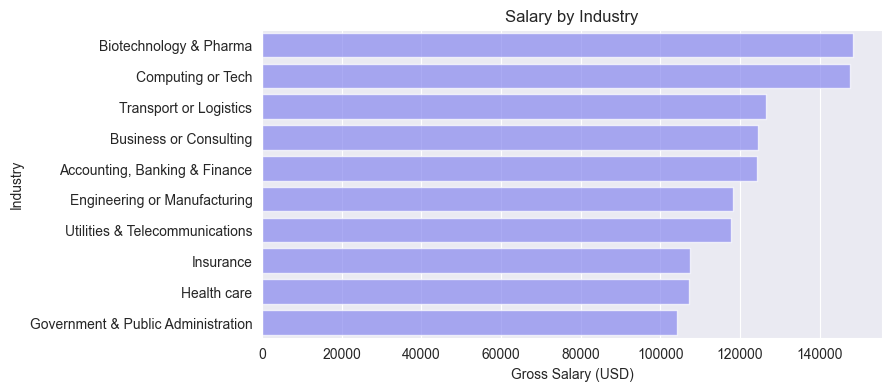

In [34]:
# How much managers do make in different industries ? 

# Filtering out rows which have less than 20 records per industry to avoid outstanding results.
industry_counts = managers['industry'].value_counts()
filtered_managers = managers[managers['industry'].map(industry_counts) > 20]

manager_salary_industry = filtered_managers.groupby('industry')["annual_salary_(gross)"].mean().to_frame().sort_values("annual_salary_(gross)", ascending=False).head(10)

sns.set_style('darkgrid')
plt.figure(figsize=(8, 4))

sns.barplot(data=manager_salary_industry, x="annual_salary_(gross)", y="industry", color="#7777ff", alpha=0.7)

plt.title("Salary by Industry")
plt.ylabel("Industry")
plt.xlabel('Gross Salary (USD)')

plt.show()

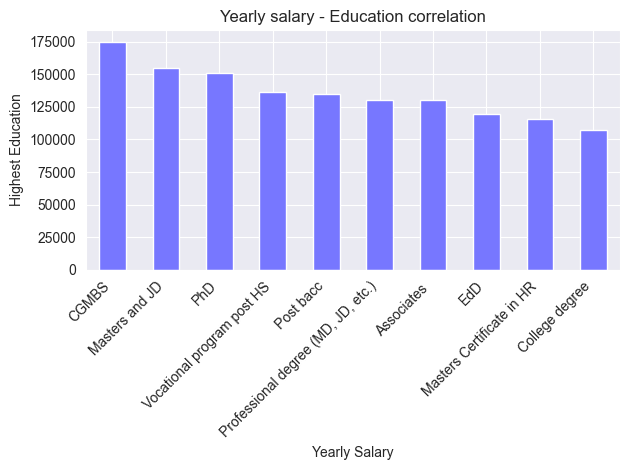

In [35]:
# Correlation between education and salaries

education_corr = managers.groupby('highest_level_of_education_completed')['annual_salary_(gross)'].mean().to_frame().sort_values('annual_salary_(gross)', ascending=False).head(10)
education_corr.plot(kind='bar', color='#7777ff', legend='')

plt.title('Yearly salary - Education correlation')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Yearly Salary')
plt.ylabel('Highest Education')
plt.tight_layout()
plt.show()